2018-03-26 12:57:41.128014
2024-03-04 12:57:41.128014
[*********************100%%**********************]  1 of 1 completed


C:\Users\91908\AppData\Roaming\Python\Python39\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


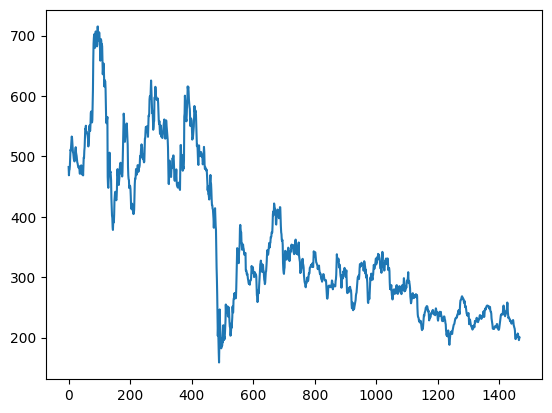

Epoch 1/5
1098/1098 - 5s - loss: 0.0191 - 5s/epoch - 5ms/step
Epoch 2/5
1098/1098 - 3s - loss: 6.7832e-04 - 3s/epoch - 3ms/step
Epoch 3/5
1098/1098 - 3s - loss: 5.6425e-04 - 3s/epoch - 3ms/step
Epoch 4/5
1098/1098 - 3s - loss: 5.4391e-04 - 3s/epoch - 3ms/step
Epoch 5/5
1098/1098 - 3s - loss: 4.7207e-04 - 3s/epoch - 2ms/step
12/12 [==============================] - 0s 2ms/step
Train RMSE: 11.29
Test RMSE: 4.00


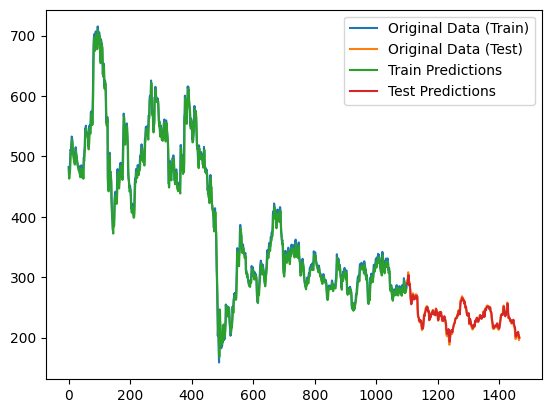

(1467, 1)
Epoch 1/5
1465/1465 - 6s - loss: 0.0100 - 6s/epoch - 4ms/step
Epoch 2/5
1465/1465 - 4s - loss: 4.9056e-04 - 4s/epoch - 3ms/step
Epoch 3/5
1465/1465 - 4s - loss: 3.7186e-04 - 4s/epoch - 3ms/step
Epoch 4/5
1465/1465 - 4s - loss: 3.6929e-04 - 4s/epoch - 3ms/step
Epoch 5/5
1465/1465 - 4s - loss: 3.8746e-04 - 4s/epoch - 3ms/step
1/1 [==============================] - 1s 708ms/step
(1468, 1)
Epoch 1/5
1466/1466 - 4s - loss: 3.8221e-04 - 4s/epoch - 3ms/step
Epoch 2/5
1466/1466 - 4s - loss: 3.7267e-04 - 4s/epoch - 3ms/step
Epoch 3/5
1466/1466 - 4s - loss: 3.7572e-04 - 4s/epoch - 3ms/step
Epoch 4/5
1466/1466 - 4s - loss: 3.7956e-04 - 4s/epoch - 3ms/step
Epoch 5/5
1466/1466 - 4s - loss: 3.7177e-04 - 4s/epoch - 3ms/step
1/1 [==============================] - 0s 25ms/step
(1469, 1)
Epoch 1/5
1467/1467 - 4s - loss: 3.7735e-04 - 4s/epoch - 3ms/step
Epoch 2/5
1467/1467 - 4s - loss: 3.7741e-04 - 4s/epoch - 3ms/step
Epoch 3/5
1467/1467 - 4s - loss: 3.6793e-04 - 4s/epoch - 3ms/step
Epoch 4/5
1

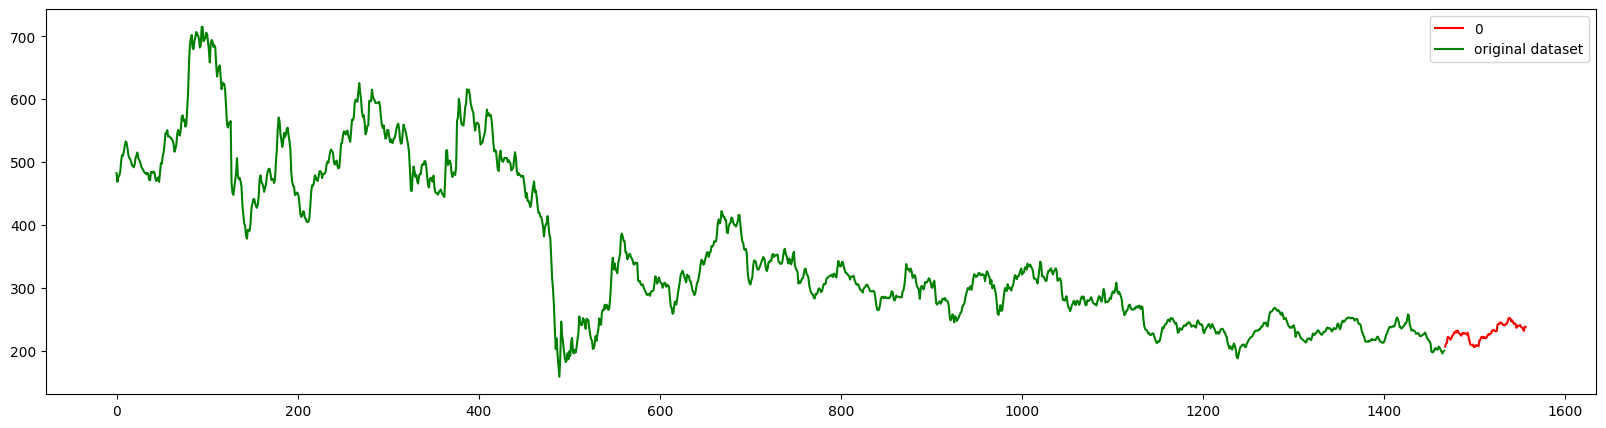

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from datetime import datetime, timedelta
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf

start_date = datetime.today() - timedelta(days=2170)
end_date = datetime.today()

print(datetime.today() - timedelta(days=2170))
print(datetime.today())

df = yf.download("BANDHANBNK.NS", start=start_date, end=end_date)

# df = df[::-1]
df = df.reset_index()

# Calculate OHLC average
OHLC_avg = df[['Open', 'High', 'Low', 'Close']].mean(axis=1)

# Plot OHLC average

OHLC_avg.plot()
plt.show()

# Scaling the data
OHLC_avg_scaled = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg_scaled = scaler.fit_transform(OHLC_avg_scaled)

# Splitting the dataset into training and test sets
train_size = int(len(OHLC_avg_scaled) * 0.75)
test_size = len(OHLC_avg_scaled) - train_size
train_OHLC, test_OHLC = OHLC_avg_scaled[0:train_size,:], OHLC_avg_scaled[train_size:len(OHLC_avg_scaled),:]

# Function to create dataset with previous day's data used to predict the next day's data
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

# Creating train and test datasets
step_size = 1
trainX, trainY = new_dataset(train_OHLC, step_size)
testX, testY = new_dataset(test_OHLC, step_size)

# Reshaping the data for LSTM input
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Model specification
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

# Making predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse scaling of predicted values
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculating RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % trainScore)

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % testScore)

# Plotting predicted values along with the original dataset
# plt.figure(figsize=(16, 8))  # Adjust size here
plt.plot(df.index[:train_size], OHLC_avg[:train_size], label='Original Data (Train)')
plt.plot(df.index[train_size:len(OHLC_avg)], OHLC_avg[train_size:len(OHLC_avg)], label='Original Data (Test)')
plt.plot(df.index[step_size:train_size-1], trainPredict, label='Train Predictions')
plt.plot(df.index[train_size+step_size:train_size+len(testPredict)+step_size], testPredict, label='Test Predictions')
plt.legend()
plt.show()

# Forecasting for the next 30 days
model_forecast = Sequential()
model_forecast.add(LSTM(32, input_shape=(1, step_size), return_sequences=True))
model_forecast.add(LSTM(16))
model_forecast.add(Dense(1))
model_forecast.compile(loss='mean_squared_error', optimizer='adam') 

new_OHLC_avg = OHLC_avg_scaled.copy()
print(new_OHLC_avg.shape)


for i in range(90):
    trainX_forecast, trainY_forecast = new_dataset(new_OHLC_avg, 1)
    trainX_forecast = np.reshape(trainX_forecast, (trainX_forecast.shape[0], 1, trainX_forecast.shape[1]))
    model_forecast.fit(trainX_forecast, trainY_forecast, epochs=5, batch_size=1, verbose=2)
    
    last_val = new_OHLC_avg[-1]
    next_val = model_forecast.predict(np.reshape(last_val, (1,1,1)))
    new_OHLC_avg = np.append(new_OHLC_avg, next_val[0])
    new_OHLC_avg = new_OHLC_avg.reshape(-1,1)
    print(new_OHLC_avg.shape)

# Inverse scaling of forecasted values
next_val = scaler.inverse_transform(new_OHLC_avg[-90:])
# next_val = scaler.inverse_transform(new_OHLC_avg[-90:])
print ("Next Day Value:", next_val)
# OHLC_avg=scaler.inverse_transform(OHLC_avg)

# df.set_index('Date', inplace=True)

# # Plotting original dataset with forecast values
# plt.figure(figsize=(20, 8))  # Adjust size here
# plt.plot(df.index, OHLC_avg, label='Original Data')
# plt.plot(pd.date_range(end=end_date, periods=7), forecast_values, label='Forecasted Values')
# plt.legend()
# plt.show()

# Plotting original dataset with forecast values
# plt.figure(figsize=(20, 8))  # Adjust size here
# plt.plot(df.index, OHLC_avg, label='Original Data')
# plt.plot(pd.date_range(end=end_date, periods=7), forecast_values[::-1], label='Forecasted Values')  # Reverse the forecasted values array
# plt.legend()
# plt.show()


s = range(len(OHLC_avg), len(OHLC_avg) + 90)
next_val = pd.DataFrame(next_val, index=list(s))
next_val.plot(figsize=(20,5), color='red', label='forecast')
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.legend()
